<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled68.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

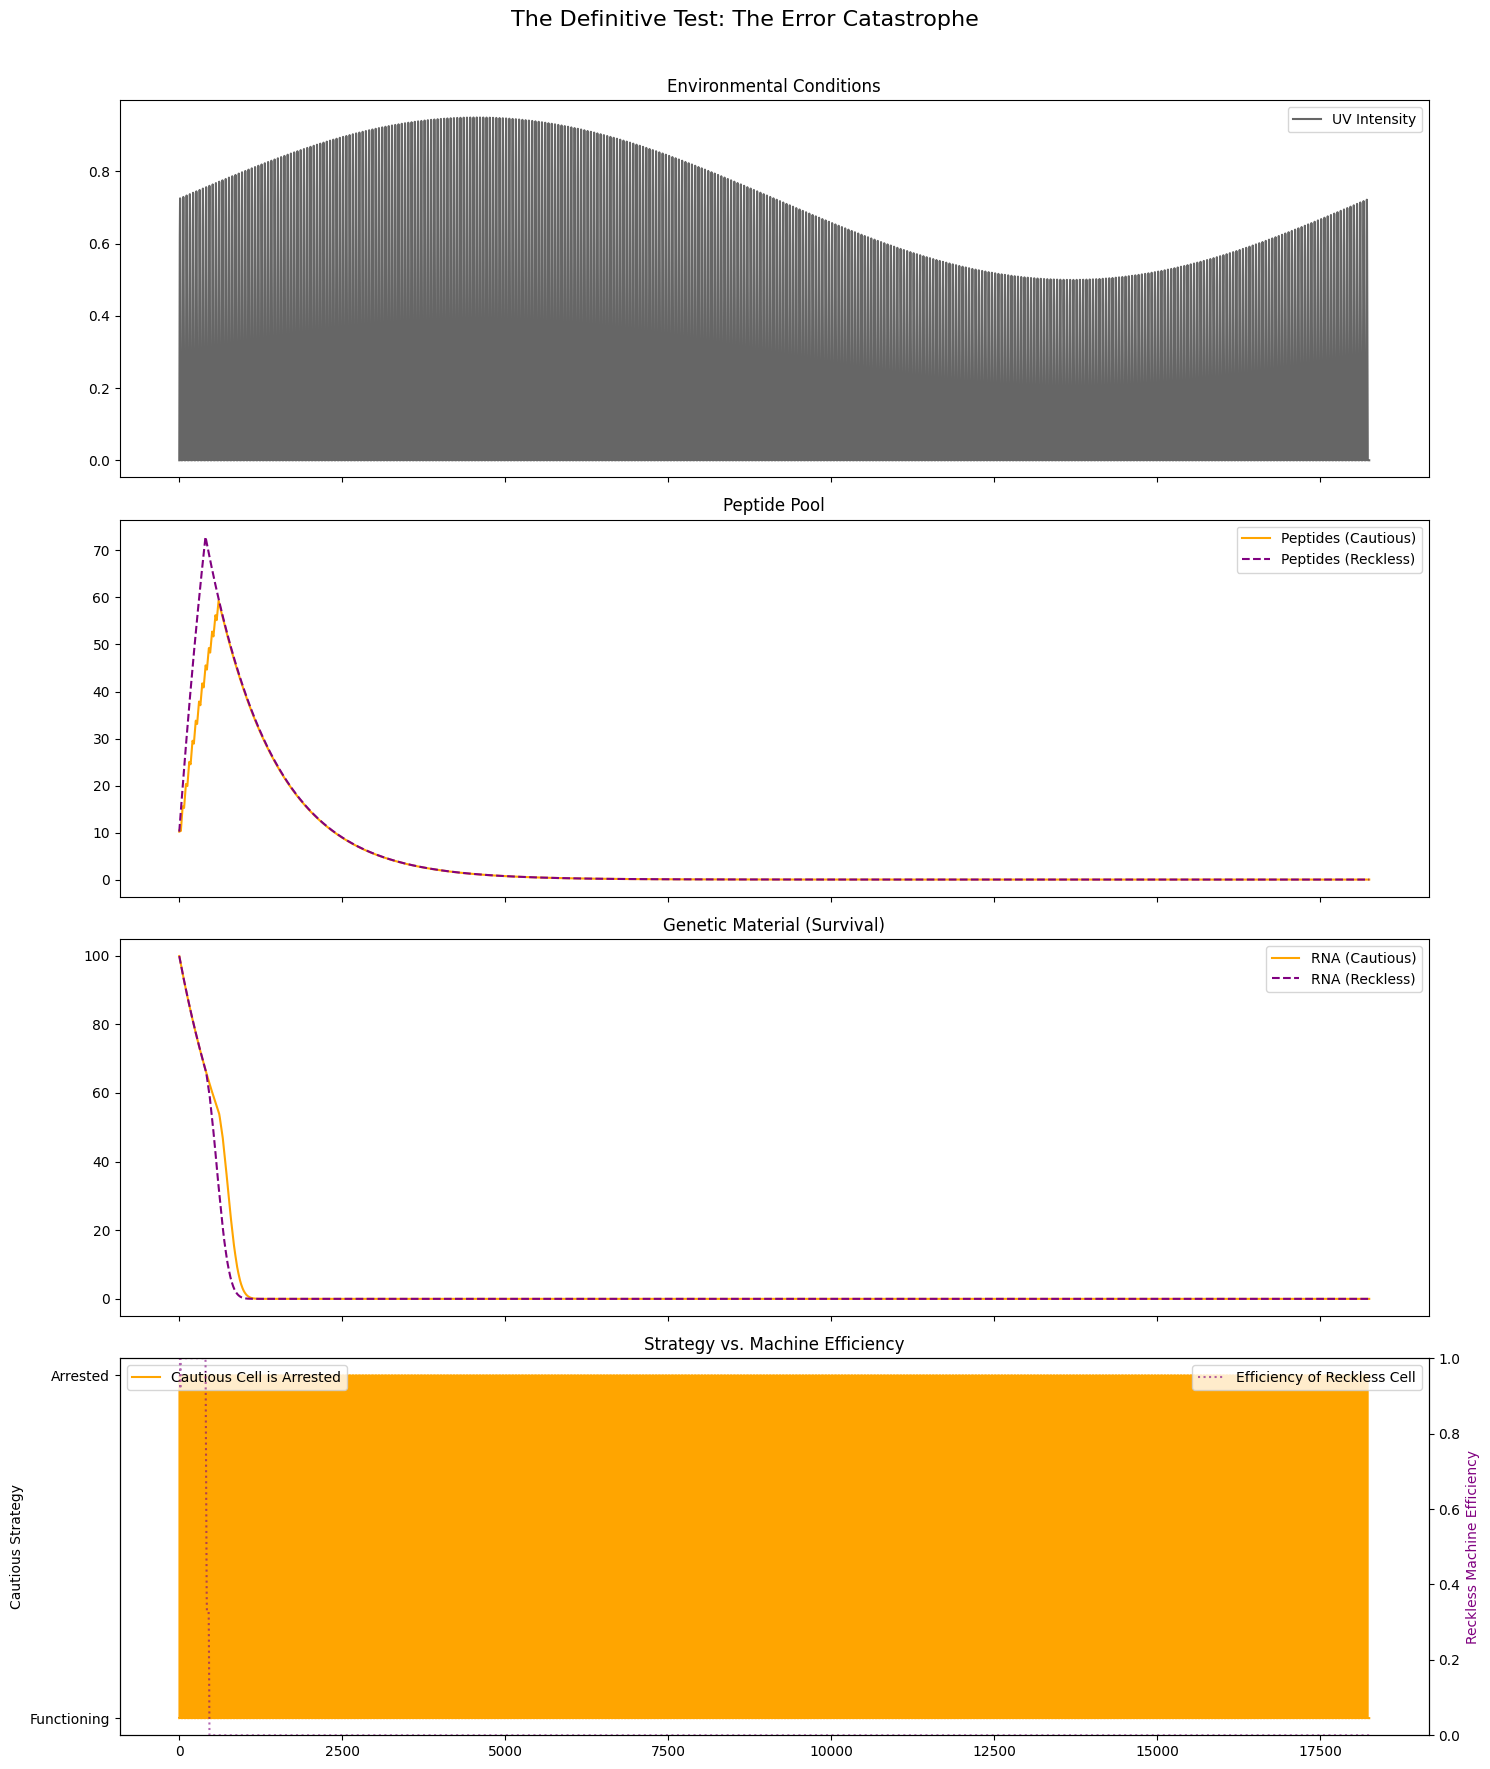

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Environment Class ---
class Environment:
    def __init__(self, total_sim_steps, days_per_cycle=50):
        self.total_sim_steps, self.days_per_cycle, self.time = total_sim_steps, days_per_cycle, 0
        num_years = total_sim_steps / (365 * days_per_cycle)
        daily_uv_cycle = np.sin(np.linspace(0, 2 * np.pi, days_per_cycle)); daily_uv_cycle[daily_uv_cycle < 0] = 0
        seasonal_amplitude_mod = 0.225 * np.sin(np.linspace(0, 2 * np.pi * num_years, total_sim_steps)) + 0.725
        self.uv_intensity = np.array([daily_uv_cycle[i % days_per_cycle] * seasonal_amplitude_mod[i] for i in range(total_sim_steps)])

    def get_current_uv(self):
        return self.uv_intensity[self.time] if self.time < self.total_sim_steps else 0.0

    def step(self):
        self.time += 1

# --- 2. RNA_Peptide_Complex Class (Error Catastrophe Logic) ---
class RNA_Peptide_Complex:
    def __init__(self, env, strategy='cautious'):
        self.env, self.strategy = env, strategy
        self.rna_pool, self.atp_pool = 100.0, 50.0
        self.mcyw_peptide_pool = 10.0
        self.internal_trp_tyr_cys_stock = 100.0
        self.rna_damage_level = 0.0
        self.is_arrested = False

        # --- PARAMETERS FOR A DECISIVE ERROR CATASTROPHE ---
        self.damage_inhibition_factor = 0.35 # HIGH: Damage severely cripples all functions
        self.uv_damage_rate = 0.6            # HIGH: Damage accumulates quickly
        self.repair_rate_base = 0.4          # MODERATE: Repair isn't instantaneous
        self.repair_cost_aas = 0.1
        self.atp_synthesis_rate_base = 0.2
        self.mcyw_synthesis_rate_base = 0.2
        self.mcyw_cost_aas = 0.2
        self.arrest_threshold = 0.25         # Sensitivity of the "fuse"
        self.degradation_rate = 0.001

    def get_health_factor(self):
        # The core of the model: the "health" of the machinery decreases with damage.
        return max(0, 1 - self.rna_damage_level * self.damage_inhibition_factor)

    def apply_uv_damage(self):
        uv = self.env.get_current_uv()
        if uv > 0:
            protection = self.mcyw_peptide_pool * 0.01
            effective_uv = uv * max(0, 1 - protection)
            damage_increase = effective_uv * self.uv_damage_rate
            self.rna_damage_level += damage_increase

            premature_stop_signal = damage_increase * 2.0
            if self.strategy == 'cautious' and premature_stop_signal > self.arrest_threshold:
                self.is_arrested = True

    def repair_damage(self):
        if self.env.get_current_uv() == 0 and self.is_arrested:
            self.is_arrested = False

        if self.rna_damage_level > 0 and self.internal_trp_tyr_cys_stock > self.repair_cost_aas:
            # Repair efficiency is now crippled by existing damage
            health_factor = self.get_health_factor()
            effective_repair_rate = self.repair_rate_base * health_factor

            repaired_amount = min(self.rna_damage_level, effective_repair_rate)
            self.rna_damage_level -= repaired_amount
            self.internal_trp_tyr_cys_stock -= self.repair_cost_aas

    def synthesize_atp(self):
        uv = self.env.get_current_uv()
        if uv > 0 and not self.is_arrested:
             health_factor = self.get_health_factor()
             self.atp_pool += self.mcyw_peptide_pool * self.atp_synthesis_rate_base * health_factor * uv

    def synthesize_peptides(self):
        if self.is_arrested: return

        health_factor = self.get_health_factor()
        cost = self.mcyw_cost_aas * health_factor

        if self.internal_trp_tyr_cys_stock > cost and health_factor > 0:
            synthesis_amount = self.mcyw_synthesis_rate_base * health_factor
            self.mcyw_peptide_pool += synthesis_amount
            self.internal_trp_tyr_cys_stock -= cost

    def degrade(self):
        # A baseline degradation of all components
        self.rna_pool *= (1 - self.degradation_rate)
        self.mcyw_peptide_pool *= (1 - self.degradation_rate)
        self.atp_pool *= (1 - self.degradation_rate)
        # RNA pool decreases faster when damaged
        self.rna_pool *= (1 - (self.rna_damage_level * self.degradation_rate * 0.5))


    def step(self):
        self.apply_uv_damage()
        self.repair_damage()
        self.synthesize_atp()
        self.synthesize_peptides()
        self.degrade()

# --- 3. Simulation Runner & Visualization ---
def run_and_plot_final():
    SIMULATION_DAYS = 365
    TOTAL_STEPS = SIMULATION_DAYS * 50

    env = Environment(TOTAL_STEPS)
    cautious = RNA_Peptide_Complex(env, strategy='cautious')
    reckless = RNA_Peptide_Complex(env, strategy='readthrough')

    data = []
    for i in range(TOTAL_STEPS):
        cautious.step()
        reckless.step()
        data.append({
            'time': env.time, 'uv': env.get_current_uv(),
            'rna_cautious': cautious.rna_pool, 'rna_reckless': reckless.rna_pool,
            'damage_cautious': cautious.rna_damage_level, 'damage_reckless': reckless.rna_damage_level,
            'peptides_cautious': cautious.mcyw_peptide_pool, 'peptides_reckless': reckless.mcyw_peptide_pool,
            'arrest_cautious': 1 if cautious.is_arrested else 0,
            'efficiency_reckless': reckless.get_health_factor()
        })
        env.step()

    df = pd.DataFrame(data)

    fig, axs = plt.subplots(4, 1, figsize=(15, 18), sharex=True)
    fig.suptitle('The Definitive Test: The Error Catastrophe', fontsize=16)
    colors = {'cautious': 'orange', 'reckless': 'purple'}

    axs[0].plot(df['time'], df['uv'], color='black', alpha=0.6, label='UV Intensity'); axs[0].set_title('Environmental Conditions'); axs[0].legend()
    axs[1].plot(df['time'], df['peptides_cautious'], color=colors['cautious'], label='Peptides (Cautious)'); axs[1].plot(df['time'], df['peptides_reckless'], color=colors['reckless'], label='Peptides (Reckless)', linestyle='--'); axs[1].set_title('Peptide Pool'); axs[1].legend()
    axs[2].plot(df['time'], df['rna_cautious'], color=colors['cautious'], label='RNA (Cautious)'); axs[2].plot(df['time'], df['rna_reckless'], color=colors['reckless'], label='RNA (Reckless)', linestyle='--'); axs[2].set_title('Genetic Material (Survival)'); axs[2].legend()

    ax3_twin = axs[3].twinx()
    axs[3].plot(df['time'], df['arrest_cautious'], color=colors['cautious'], label='Cautious Cell is Arrested', drawstyle='steps-post')
    ax3_twin.plot(df['time'], df['efficiency_reckless'], color=colors['reckless'], alpha=0.6, linestyle=':', label='Efficiency of Reckless Cell')
    axs[3].set_yticks([0, 1]); axs[3].set_yticklabels(['Functioning', 'Arrested'])
    axs[3].set_ylabel('Cautious Strategy')
    ax3_twin.set_ylabel('Reckless Machine Efficiency', color=colors['reckless'])
    ax3_twin.set_ylim(0, 1)
    axs[3].set_title('Strategy vs. Machine Efficiency'); axs[3].legend(loc='upper left'); ax3_twin.legend(loc='upper right')

    plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()

if __name__ == "__main__":
    run_and_plot_final()
